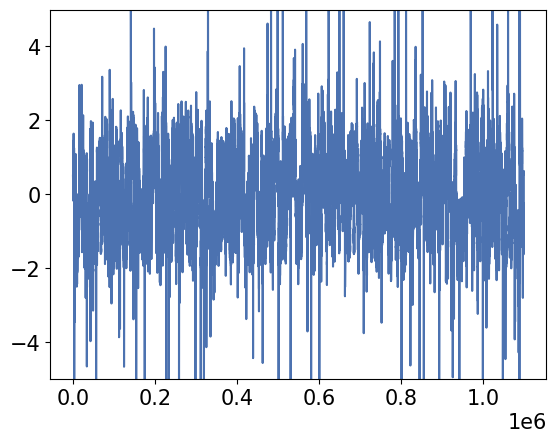

目录 C:\Users\LENOVO\Desktop\RC for Levy\data 创建成功或者已经存在。
0.9186265172114754


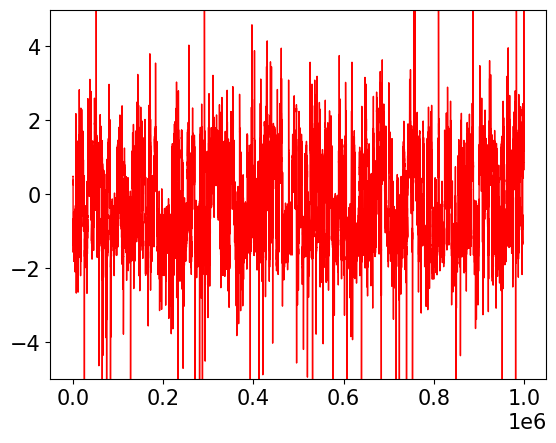

np.max(original): 4.714668687884277
np.max(separated): 4.716459860916759


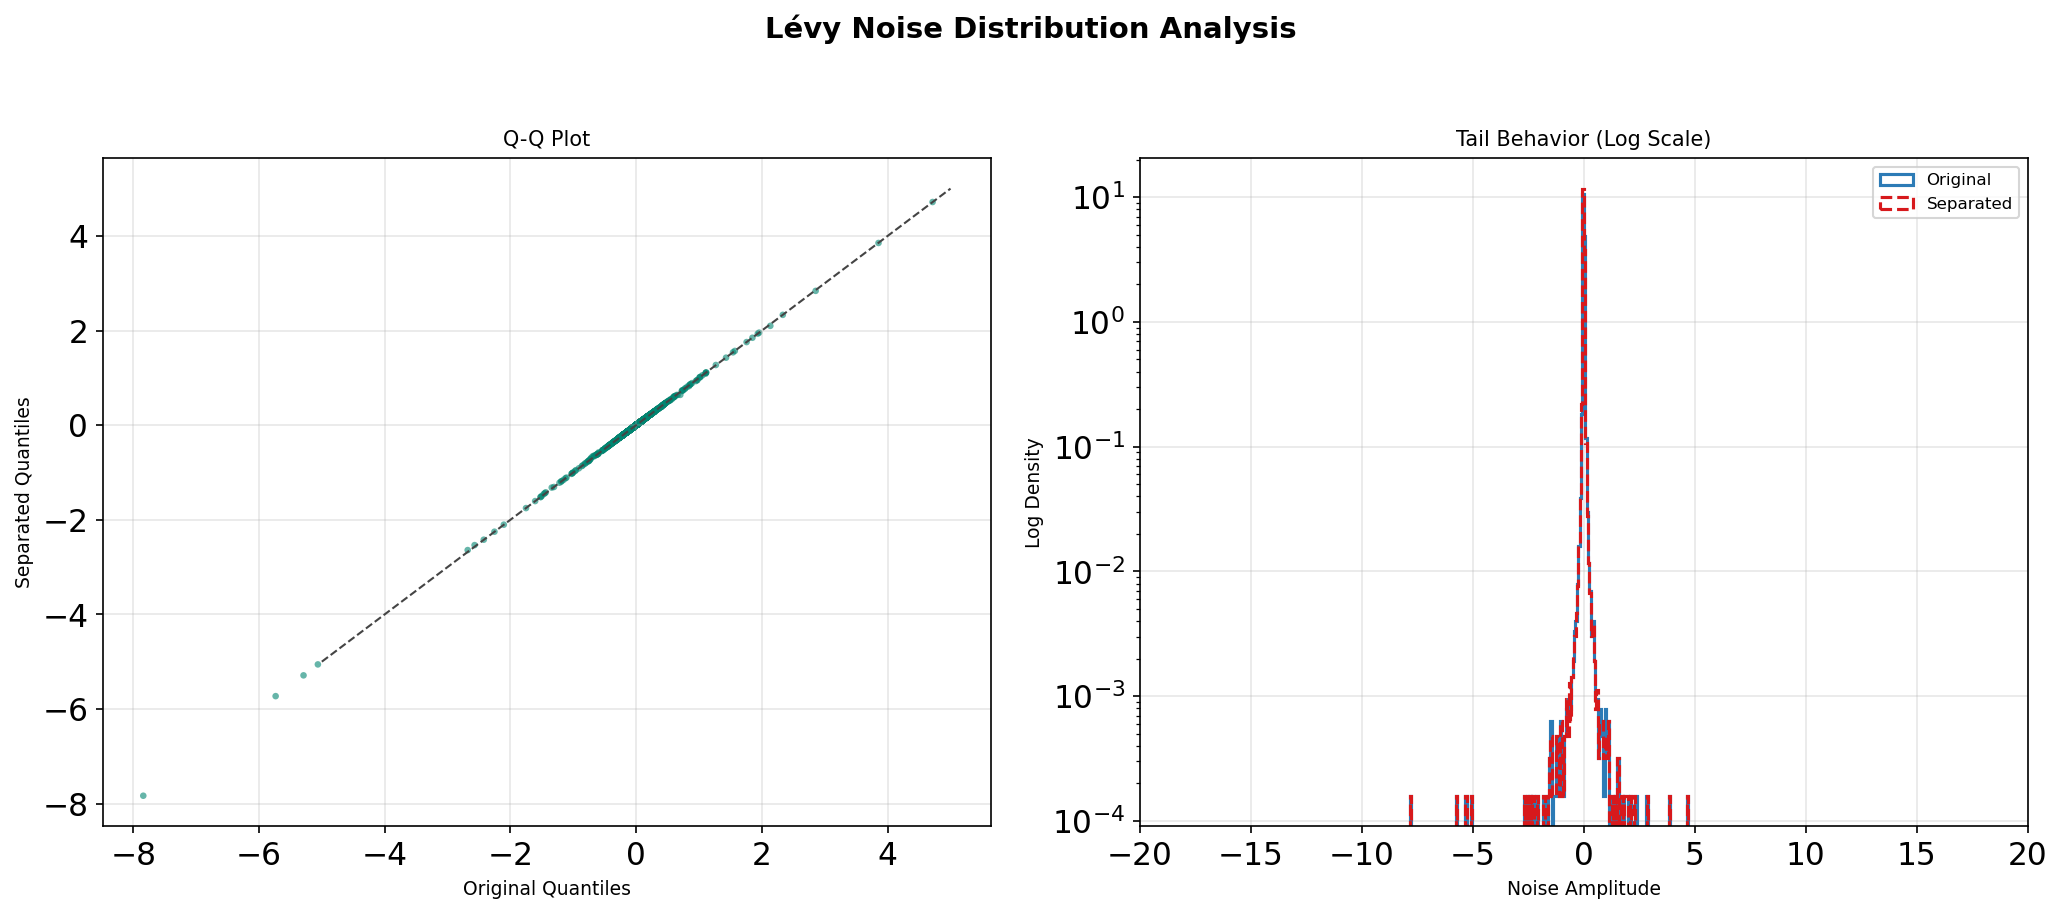

predict =1 , 在画预测


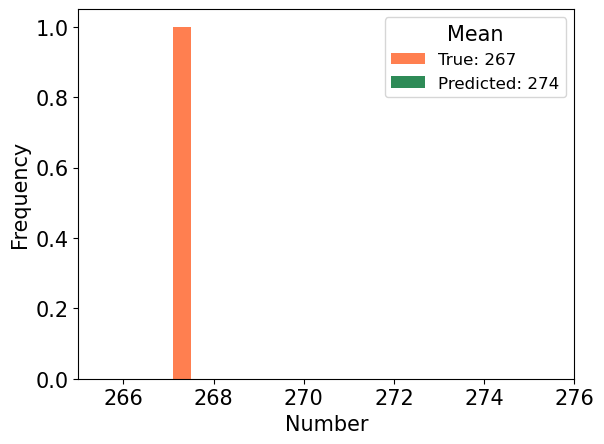

T_atimes [267]
T_ptimes [274]


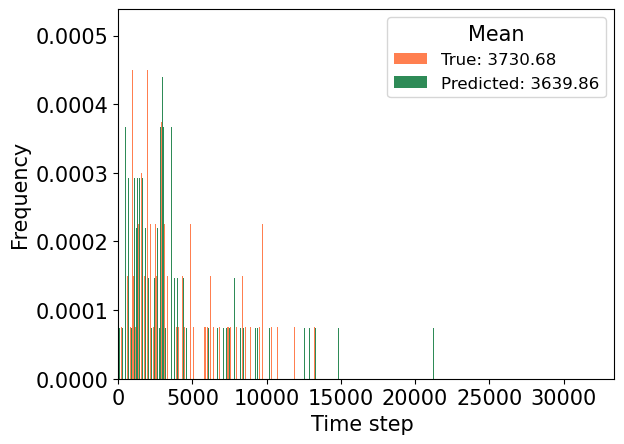

T_ainterval (267,)
T_pinterval (274,)


In [1]:
import numpy as np
import networkx as nx
import os.path
import matplotlib.pyplot as plt
import time
import math
from sde_simulator import SDESimulator
from noise_visualizer import plot_levy_comparison
import gc
gc.collect()
import warnings
warnings.filterwarnings("ignore")
import os
os.system('cls' if os.name == 'nt' else 'clear')
plt.rc('font',size=15)
np.float = np.float64
UseDoubleWell=1
RCType=0# Different RC architecture: 0 deterministic RC to learn noise; 1/2 with noise in/out side tanh
        # In our work, RCType=0
dt = 0.001; #steplength, you only need to change the dt here
Testtime = 1000
TestLength=int(Testtime/dt) # Number of points for test/validation phase: 0.01 steplength
Traintime= 100
T2 =Traintime+Testtime # Total time length
T_atimes=[]
T_ptimes=[]
T_ainterval=[]
T_pinterval=[]
anoise=[]

start = time.time() 
"""SDE: double well
"""
#self.M is the ODE's dimension
#self.N is the number of reservoir node
#self.S is training data
#self.R is collection of reservoir state vectors: bias, reservoir variable, system variable
#self.r seems the reservoir variables

def distribution(data,T_times,T_interval):  #To evaluate the transition time and number
    '''
    Change the time series to three numbers: 
        -1 if <0
        0 if =0
        1 if >0
    and put these results in sign,
    '''
    xshape=np.shape(data)[0]
    yshape=np.shape(data)[1]  
    count=0
    index_up=0
    index_down=0
    length=max(xshape,yshape)
    diff=[]
    position=[]      
    if yshape > xshape: 
        data = data.T
    sign=np.sign(data)
    
    '''
    Consider where the symbol changed, and put these results in position,
    when changed, transition might happen.
    '''
    for i in range (length-1):
        diff.append(sign[i+1,0]-sign[i,0])
        if diff[i]!=0:
            position.append(i)
    
    '''
    Initialization
    '''            
    for i in range (np.shape(sign)[0]):
        if sign[i,0]!=0:
            state=sign[i,0]
            index_up=i
            index_down=i
            break
    
    '''
    Evaluation
    '''        
    for i in range (len(position)):
        if i!=len(position)-1:
            if state<0:
                if diff[position[i]]>0:
                    if np.max(data[position[i]:position[i+1],0])>=1 :
                        peroid=data[position[i]:position[i+1],0]
                        index_up=list(peroid>=1).index(True) + position[i]
                        T_interval.append(index_up-index_down)
                        state=1
                        count+=1
                                
            elif state>0:
                if diff[position[i]]<0:
                    if np.min(data[position[i]:position[i+1],0])<=-1 : 
                        peroid=data[position[i]:position[i+1],0]
                        index_down=list(peroid<=-1).index(True) + position[i]
                        T_interval.append(index_down-index_up)
                        state=-1
                        count+=1
        else:
            if state<0:
                if diff[position[i]]>0:
                    if np.max(data[position[i]:,0])>=1 :
                        peroid=data[position[i]:,0]
                        index_up=list(peroid>=1).index(True) + position[i]
                        T_interval.append(index_up-index_down)
                        state=1
                        count+=1
            elif state>0:
                if diff[position[i]]<0:
                    if np.min(data[position[i]:,0])<=-1 : 
                        peroid=data[position[i]:,0]
                        index_down=list(peroid<=-1).index(True) + position[i]
                        T_interval.append(index_down-index_up)
                        state=-1
                        count+=1
    T_times.append(count)
   

    
def draw_distribution(a,b,title,xlable,bins_interval=1,margin=1):  #To draw the PDF of evaluation between test and predicted data
    '''
    This part is to draw the PDF between a and b
    '''
    data=[a,b]
    left = min(np.min(a),np.min(b))
    right = max(np.max(a),np.max(b))
    bins= np.arange(math.floor(left), math.ceil(right), bins_interval)
    plt.xlim(math.floor(left) - margin, math.ceil(right) + margin)
    plt.xlabel(xlable) 
    plt.ylabel('Frequency')   
    plt.hist(data, bins=bins, density=True, color=['coral','seagreen'])
    if xlable == 'Number' :
        plt.legend(['True: '+str(round(np.mean(a))),'Predicted: '+str(round(np.mean(b)))],title='Mean',fontsize=12,loc='upper right')
    else:
        plt.legend(['True: '+str(round(np.mean(a),2)),'Predicted: '+str(round(np.mean(b),2))],title='Mean' ,fontsize=12,loc='upper right')
    # plt.savefig('../results/' + title + '.pdf',bbox_inches = 'tight')
    plt.show()
    

def DoubleWell(para):  #Generate dataset
    '''
    In this function, we generate the training and predicting sets from SDE (using Euler method).
    '''
    np.random.seed(42)
    sim = SDESimulator()
    para = [1.5, 0.5, 1, T2, dt]  # [alpha, X0, eps, T, dt]
    u, dL = sim.simulate_sde(para, 'levy')
    plt.plot(u)
    # plt.xlim(0,10000)
    plt.ylim(-5,5)
    plt.show()
    plt.close()


 
    u=u.reshape(1,-1)
    u_t=np.zeros((1,TestLength))
    u_t[0,:]=u[0,int(Traintime/dt)+1:int(T2/dt)+1]
    distribution(u_t,T_atimes,T_ainterval)




    # # 获取当前脚本文件的绝对路径
    # current_script_path = os.path.abspath(__file__)

            # 获取当前脚本文件所在的目录
    current_script_dir = os.getcwd()

                    # 要创建的目录路径
    DATA_DIR = os.path.join(current_script_dir, 'data')

    # # 获取上一级目录
    # parent_dir = os.path.dirname(current_script_dir)

    # 要创建的目录路径
    DATA_DIR = os.path.join(current_script_dir, 'data')

    # 创建目录
    os.makedirs(DATA_DIR, exist_ok=True)

    # 检查目录是否创建成功
    if os.path.exists(DATA_DIR):
        print(f"目录 {DATA_DIR} 创建成功或者已经存在。")
    else:
        print(f"目录 {DATA_DIR} 创建失败。")

# 以下是模拟你的其他代码逻辑
     # 保存训练+测试数据
    np.save(os.path.join(DATA_DIR, 'original data.npy'), u) 
    # 保存测试数据段
    np.save(os.path.join(DATA_DIR, 'test_data.npy'), u_t)

    
    return u, dL

class Reservoir:
    def __init__(self,Utotal,hyperparameters):      
        '''
        Initialize the reservoir, input the training set, initialize some parameters, and input hyperparameters
        '''
        # Input layer
        u=Utotal[0]
        self.NumBifurPara=np.shape(Utotal)[0]   
        self.M = u.shape[0]  
        self.input_len = u.shape[1]
        self.dataset = Utotal

        # Reservoir layer
        '''
        Parameter N can be adjusted (self.N), and dimensions for the input (self.dimensions) should be adjusted.
        '''     
        self.N = int(400)
        self.dimensions = 1
        self.P = u.shape[0]
        self.bias = 0
        
        # Training relevant: have used their ratio of separating the input data
        self.init_len = 0
        self.train_len = int(Traintime / dt) 
        self.test_len = int(Testtime / dt) 
        # self.train_len = np.int(self.input_len-TestLength-1)
        # self.test_len = np.int(TestLength)
        self.error_len = np.int(TestLength)
        self.T2=self.input_len
        
        # Hyperparameters to be optimized: here set their initial value of hyperparameters
        self.kin =hyperparameters[0] # uniform distribution of $[-k_{in},k_{in}]$ of W_{in}, W_{b}, W_{\epsilon}
        self.D = hyperparameters[1] # degree of reservoir matrix A ...  #What is the degree function in their code: the degree of the renyi-Erdos network
        self.rho = hyperparameters[2] # spectral radius: rho  -> "appropriately scaled by its largest eigenvalue ρ."
        self.alpha =hyperparameters[3] 
        self.beta = hyperparameters[4] 
        self.parab=0 #set as zero for now, because no para-layer yet
        self.parak=0 #set as zero for now, because no para-layer yet
        self.paraepsilon=0 #epsilon for RC and consistent with SDE model

        
    def train(self,parascanRange): #To train the matrix W_{out}       
        '''
         Randomly generate Matrics W_{in}, W_{b}, and W_{xi} for input, 
         based on the uniform distribution in [-K_{in}, K_{in}],
         an ER network (g) with average degree D is to describe the connections of the nodes in reservoir,
         A is the adjacency matrix of g, and adjust its spectral radius by rho.
         This part is to train the output matrix W_{out} with the regression:
             W_{out}=\left(\mathbf{U R}^{\boldsymbol{\top}}\right) \cdot\left(\mathbf{R} \mathbf{R}^{\boldsymbol{\top}}+\beta\right)^{-1},
        '''
        self.Win =np.random.uniform(-self.kin,self.kin, (self.N, self.M + 1))
        self.Wb= np.random.uniform(-self.kin, self.kin, (self.N, 1))
        self.Wxi=np.random.uniform(-self.kin,self.kin, (self.N, self.M)) 
        # TODO: the values of non-zero elements are randomly drawn from uniform dist [-1, 1]
        g = nx.erdos_renyi_graph(self.N, self.D / self.N, 42, True)
        self.A = nx.adjacency_matrix(g).todense()
        # spectral radius: rho  -> "appropriately scaled by its largest eigenvalue ρ."
        self.A =self.A *1.25 /self.rho
        print(max(abs(np.linalg.eig(self.A)[0])))
        
        # run the reservoir with the data and collect r
        self.rFinalTrainTotal=[]
        for index in range(self.NumBifurPara):
            self.paralayer=parascanRange[index]
            self.R = np.zeros(
                    (1 + self.N + self.M, self.train_len-self.init_len ))
                # collection of input signals
            self.S = np.vstack((x[self.init_len + 1: self.train_len + 1] for x in self.dataset[index])) # make multi-dimensional input data from training window
            self.r = np.zeros((self.N, 1))
            for t in range(self.train_len):
                V = np.vstack((x[t] for x in self.dataset[index]))
                Xi= np.random.normal(0,1, (self.M, 1))
                if RCType==0:
                    #RC0: 0 deterministic RC to learn noise
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                if t >= self.init_len:
                    self.R[:, [t - self.init_len]
                           ] = np.vstack((self.bias, V, self.r))[:, 0]
            if index==0:
                self.RTotal=self.R
                self.STotal=self.S             
            else:            
                self.RTotal=np.append(self.RTotal,self.R, axis=1)
                self.STotal=np.append(self.STotal,self.S, axis=1)
            self.rFinalTrainTotal.append(self.r[:,-1])

        # train the output
        R = self.RTotal  # Transpose
        R_T=R.T        
        self.Wout = np.dot(np.dot(self.STotal, R_T), np.linalg.inv(
            np.dot(self.RTotal, R_T) + self.beta * np.eye(self.M + self.N + 1)))
        return self.Wout

    def train2(self,WoutPara): # To seperate noise
        '''
        This part is to seperate the noise (Training phase)
        '''
        global t
        self.SampledNoise = []
        testnoise = []
        np.random.seed(42)
        for index in range(self.NumBifurPara):

            self.paralayer=parascanRange[index]
            self.R = np.zeros(
                    (1 + self.N + self.M, self.train_len - self.init_len))
            self.S = np.vstack((x[self.init_len + 1: self.train_len + 1] for x in self.dataset[index])) # make multi-dimensional input data from training window
            self.r = np.zeros((self.N, 1))
            for t in range(self.train_len):
                V = np.vstack((x[t] for x in self.dataset[index]))
             
                #RC0: 0 deterministic RC to learn noise
                self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                s = np.dot(WoutPara, np.vstack((self.bias, V, self.r)))
                self.S[:, t] = np.squeeze(np.asarray(s))                
            for i in range(self.dimensions):
              X=self.dataset[index][np.array(range(int(self.P/self.dimensions)))*self.dimensions+i, 1: self.train_len + 1]
              Y=self.S[np.array(range(int(self.P/self.dimensions)))*self.dimensions+i, 0: self.train_len ] ####    #self.dataset[range(self.P)*self.dimensions+i, self.train_len+1: self.train_len+self.error_len+1]
              for j in range(X.shape[1]):
                  XX=np.array(X[:,j])  
                  YY=np.array(Y[:,j])
                  NoiseTemp=XX-YY
                  testnoise.append(NoiseTemp) 


              self.SampledNoise.append(testnoise) 
            #    # 保存 SampledNoise 数组到当前路径下的 sampled_noise.npy 文件
            #   current_dir = os.path.dirname(os.path.abspath(__file__))
            #   params_dir = f"train_{int(self.train_len)}_test_{int(self.test_len)}"  # 添加下划线和括号闭合
            #   save_dir = os.path.join(current_dir, params_dir)
            #   os.makedirs(save_dir, exist_ok=True)  # <--- 新增创建目录命令
            #   np.save(os.path.join(save_dir, 'separated_noise.npy'), testnoise)
            #   print("保存了")
    
    def _run(self,WoutPara,Load,Predict):
        '''
        run the trained ESN in alpha generative mode. no need to initialize here,
        because r is initialized with training data and we continue from there.

        The value of the switches are really important:
            Load=0 and Predict=0 to draw the deterministic part (slow-scale time series with different initial points),
            Load=1 and Predict=0 to draw the deterministic part and the distribution of the seperated noise,
                here, need to import the matrics saved when Load=0,
            Load=1 and Predict=0 to draw the predicted data and the distribution of the seperated noise,
            here, need to import the matrics saved when Load=0,
            and evaluation would run.
        '''
        output=[]
        if Load==0: # to save the matrics we generated
    
           # 生成超参数文件夹名（例如：K4_D4_rho4000_a0.1_b1e-8）
         params_dir = (
            f"N_{int(self.N)}_K{int(self.kin)}_D{int(self.D)}_rho{int(self.rho)}"
            f"_a{self.alpha}_b{self.beta:.0e}".replace("e-0", "e-").replace("e+0", "e+")
        )
        
        # 创建文件夹（如果不存在）
         # current_dir = os.path.dirname(os.path.abspath(__file__))
         current_dir = os.getcwd()
         save_dir = os.path.join(current_dir, params_dir)
         os.makedirs(save_dir, exist_ok=True)
        
        # 保存文件到该文件夹（文件名保持简洁）
         np.save(os.path.join(save_dir, 'Winw.npy'), self.Win)
         np.save(os.path.join(save_dir, 'Aw.npy'), self.A)
         np.save(os.path.join(save_dir, 'WoutParaw.npy'), WoutPara)
         np.save(os.path.join(save_dir, 'Wb.npy'), self.Wb)
         np.save(os.path.join(save_dir, 'Wxi.npy'), self.Wxi)
         np.save(os.path.join(save_dir, 'r.npy'), self.rFinalTrainTotal)

        # current_dir = os.path.dirname(os.path.abspath(__file__))
        # np.save(os.path.join(current_dir, 'Winw.npy'), self.Win)
        # np.save(os.path.join(current_dir, 'Aw.npy'), self.A)
        # np.save(os.path.join(current_dir, 'WoutParaw.npy'), WoutPara)
        # np.save(os.path.join(current_dir, 'Wb.npy'), self.Wb)
        # np.save(os.path.join(current_dir, 'Wxi.npy'), self.Wxi)
        # np.save(os.path.join(current_dir, 'r.npy'), self.rFinalTrainTotal)
            
        else:  # to load the matrics we saved
            ### 从上面那个save 路径来load 即可
            params_dir = (
            f"N_{int(self.N)}_K{int(self.kin)}_D{int(self.D)}_rho{int(self.rho)}"
            f"_a{self.alpha}_b{self.beta:.0e}".replace("e-0", "e-").replace("e+0", "e+")
        )
        
        # 加载文件
            current_dir = os.getcwd()
            save_dir = os.path.join(current_dir, params_dir)
            self.Win = np.load(os.path.join(save_dir, 'Winw.npy'))
            self.A = np.load(os.path.join(save_dir, 'Aw.npy'))
            WoutPara = np.load(os.path.join(save_dir, 'WoutParaw.npy'))
            self.Wb = np.load(os.path.join(save_dir, 'Wb.npy'))
            self.Wxi = np.load(os.path.join(save_dir, 'Wxi.npy'))
            self.rFinalTrainTotal = np.load(os.path.join(save_dir, 'r.npy'))
            

            # current_dir = os.path.dirname(os.path.abspath(__file__))
            # self.Win = np.load(os.path.join(current_dir, 'Winw.npy'))
            # self.A = np.load(os.path.join(current_dir, 'Aw.npy'))
            # WoutPara = np.load(os.path.join(current_dir, 'WoutParaw.npy'))
            # self.Wb = np.load(os.path.join(current_dir, 'Wb.npy'))
            # self.Wxi = np.load(os.path.join(current_dir, 'Wxi.npy'))
            # self.rFinalTrainTotal = np.load(os.path.join(current_dir, 'r.npy'))
        
        # Predicted data
        self.S = np.zeros((self.P, self.test_len))
        self.S_1 = np.zeros((self.P, self.test_len))
        self.S_2 = np.zeros((self.P, self.test_len))
        self.S_3 = np.zeros((self.P, self.test_len))
        self.S_4 = np.zeros((self.P, self.test_len))
        self.S_5 = np.zeros((self.P, self.test_len))
        self.S_6 = np.zeros((self.P, self.test_len))
        self.S_7 = np.zeros((self.P, self.test_len))
        self.S_8 = np.zeros((self.P, self.test_len))
        self.S_9 = np.zeros((self.P, self.test_len))     
        
        # Input of the reservoir
        for index in range(self.NumBifurPara):
            V = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_1 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_2 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_3 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_4 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_5 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_6 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_7 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_8 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_9 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            
            
            # Different initial points
            if Predict == 0:
                V[:,0]=0
                V_1[:,0] =1.5
                V_2[:,0]=0.5
                V_3[:,0]=-0.5
                V_4[:,0]=-1.5
                V_5[:,0]=0.75
                V_6[:,0]=-0.75
                V_7[:,0]=1.25
                V_8[:,0]=-1.25
                V_9[:,0]=0.25
            
            # Reservoir states
            if Predict == 0:
                self.r=self.rFinalTrainTotal[index]
                self.r_1=self.rFinalTrainTotal[index]
                self.r_2=self.rFinalTrainTotal[index]
                self.r_3=self.rFinalTrainTotal[index]
                self.r_4=self.rFinalTrainTotal[index]
                self.r_5=self.rFinalTrainTotal[index]
                self.r_6=self.rFinalTrainTotal[index]
                self.r_7=self.rFinalTrainTotal[index]
                self.r_8=self.rFinalTrainTotal[index]
                self.r_9=self.rFinalTrainTotal[index]
            else:
                self.r=self.rFinalTrainTotal[index]*0
     
            
            if RCType==0:               
                global NoiseToUse
                NoiseToUse=np.array(self.SampledNoise)
                np.random.seed(42)  # 如果需要可重复性，设置一次即可
                Levy_noise = np.random.choice(
                  NoiseToUse[0, :, 0].flatten(), 
                  size=self.test_len,  # 生成与预测步数相同的噪声序列
                  replace=True         # 允许重复采样
                  )
            for t in range(self.test_len):
                # r(t + \Delta t) = (1 - alpha)r(t) + alpha * tanh(A * r(t) + Win * V(t) + bias)
                if RCType==0:
                    #RC0: 0 deterministic RC to learn noise
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                                          
                    if Predict == 0:
                    
                        self.r_1 = (1 - self.alpha) * self.r_1 + self.alpha * np.tanh(np.dot(self.A,self.r_1) 
                              + np.dot(self.Win, np.vstack((self.bias, V_1)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                              
                        self.r_2 = (1 - self.alpha) * self.r_2 + self.alpha * np.tanh(np.dot(self.A,self.r_2) 
                              + np.dot(self.Win, np.vstack((self.bias, V_2)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                              
                        self.r_3 = (1 - self.alpha) * self.r_3 + self.alpha * np.tanh(np.dot(self.A,self.r_3) 
                              + np.dot(self.Win, np.vstack((self.bias, V_3)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_4 = (1 - self.alpha) * self.r_4 + self.alpha * np.tanh(np.dot(self.A,self.r_4) 
                              + np.dot(self.Win, np.vstack((self.bias, V_4)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_5 = (1 - self.alpha) * self.r_5 + self.alpha * np.tanh(np.dot(self.A,self.r_5) 
                              + np.dot(self.Win, np.vstack((self.bias, V_5)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_6 = (1 - self.alpha) * self.r_6 + self.alpha * np.tanh(np.dot(self.A,self.r_6) 
                              + np.dot(self.Win, np.vstack((self.bias, V_6)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_7 = (1 - self.alpha) * self.r_7 + self.alpha * np.tanh(np.dot(self.A,self.r_7) 
                              + np.dot(self.Win, np.vstack((self.bias, V_7)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_8 = (1 - self.alpha) * self.r_8 + self.alpha * np.tanh(np.dot(self.A,self.r_8) 
                              + np.dot(self.Win, np.vstack((self.bias, V_8)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_9 = (1 - self.alpha) * self.r_9 + self.alpha * np.tanh(np.dot(self.A,self.r_9) 
                              + np.dot(self.Win, np.vstack((self.bias, V_9)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                
                
                if np.isnan(np.sum(np.sum(np.array(self.r)))):
                    print('R')
                    print(np.max(V))
                    print(np.max(np.max(WoutPara)),np.min(np.min(WoutPara)))
                
                # Output of the reservoir
                s = np.dot(WoutPara, np.vstack((self.bias, V, self.r)))  
                if Predict ==0:            
                    s_1 = np.dot(WoutPara, np.vstack((self.bias, V_1, self.r_1)))
                    s_2 = np.dot(WoutPara, np.vstack((self.bias, V_2, self.r_2)))
                    s_3 = np.dot(WoutPara, np.vstack((self.bias, V_3, self.r_3)))
                    s_4 = np.dot(WoutPara, np.vstack((self.bias, V_4, self.r_4)))
                    s_5 = np.dot(WoutPara, np.vstack((self.bias, V_5, self.r_5)))
                    s_6 = np.dot(WoutPara, np.vstack((self.bias, V_6, self.r_6)))
                    s_7 = np.dot(WoutPara, np.vstack((self.bias, V_7, self.r_7)))
                    s_8 = np.dot(WoutPara, np.vstack((self.bias, V_8, self.r_8)))
                    s_9 = np.dot(WoutPara, np.vstack((self.bias, V_9, self.r_9)))
      
                
                self.S[:, t] = np.squeeze(np.asarray(s))
                if Predict ==0:
                    self.S_1[:, t] = np.squeeze(np.asarray(s_1))
                    self.S_2[:, t] = np.squeeze(np.asarray(s_2))
                    self.S_3[:, t] = np.squeeze(np.asarray(s_3))
                    self.S_4[:, t] = np.squeeze(np.asarray(s_4))
                    self.S_5[:, t] = np.squeeze(np.asarray(s_5))
                    self.S_6[:, t] = np.squeeze(np.asarray(s_6))
                    self.S_7[:, t] = np.squeeze(np.asarray(s_7))
                    self.S_8[:, t] = np.squeeze(np.asarray(s_8))
                    self.S_9[:, t] = np.squeeze(np.asarray(s_9))
                              
                if RCType==0:
                   
                    self.S[:, t] = self.S[:, t]
                    if Predict ==0:
                        self.S_1[:, t] = self.S_1[:, t]
                        self.S_2[:, t] = self.S_2[:, t]
                        self.S_3[:, t] = self.S_3[:, t]
                        self.S_4[:, t] = self.S_4[:, t]
                        self.S_5[:, t] = self.S_5[:, t]
                        self.S_6[:, t] = self.S_6[:, t]
                        self.S_7[:, t] = self.S_7[:, t]
                        self.S_8[:, t] = self.S_8[:, t]
                        self.S_9[:, t] = self.S_9[:, t]
                # np.random.seed(42)    
                
                if Predict == 0:
                    V = s
                    V_1= s_1 
                    V_2 = s_2
                    V_3 = s_3
                    V_4 = s_4
                    V_5 = s_5
                    V_6 = s_6
                    V_7 = s_7
                    V_8 = s_8
                    V_9 = s_9
                else:
                    # Levy_noise_index = np.random.randint(0, self.test_len-1) # Sample noise from distribution
                    # V = s +  NoiseToUse[0,Levy_noise_index,0]

                   
                    V = s +  Levy_noise[t]
                    output.append(V)
                    
            if Predict == 1:
                output=np.array(output)
                Output=output.reshape(1,self.test_len)


                           # 获取当前脚本文件所在的目录
                current_script_dir = os.getcwd()

                    # 要创建的目录路径
                DATA_DIR = os.path.join(current_script_dir, 'data')

                # 要创建的目录路径
                DATA_DIR = os.path.join(current_script_dir, 'data')

                # 创建目录
                os.makedirs(DATA_DIR, exist_ok=True)
                np.save(os.path.join(DATA_DIR, 'predicted data.npy'), Output)


                plt.plot(Output[0,:],color='red',linewidth=1,linestyle='-')
                # plt.xlim(0, 10000)
                plt.ylim(-5,5)
                # plt.xlim(0)
                plt.show()
                distribution(Output,T_ptimes,T_pinterval)
            
            if Predict == 0:  
                plt.xlabel('Time(s)')
                # plt.ylim(-2,2)
                x = np.linspace(self.test_len*dt,int(T2),self.test_len)
                plt.axhline(1,linestyle='--',color='navy',alpha=0.5)
                plt.axhline(-1,linestyle='--',color='navy',alpha=0.5)
                plt.ylabel('$u_1$')
                plt.plot(x,self.S[0,:],color='red',linewidth=1,linestyle='-') 
                plt.plot(x,self.S_1[0,:],color='blue',linewidth=1,linestyle='-')
                plt.plot(x,self.S_2[0,:],color='green',linewidth=1,linestyle='-')
                plt.plot(x,self.S_3[0,:],color='black',linewidth=1,linestyle='-')
                plt.plot(x,self.S_4[0,:],color='grey',linewidth=1,linestyle='-')
                plt.plot(x,self.S_5[0,:],color='yellow',linewidth=1,linestyle='-')
                plt.plot(x,self.S_6[0,:],color='pink',linewidth=1,linestyle='-')
                plt.plot(x,self.S_7[0,:],color='purple',linewidth=1,linestyle='-')
                plt.plot(x,self.S_8[0,:],color='orange',linewidth=1,linestyle='-')
                plt.plot(x,self.S_9[0,:],color='brown',linewidth=1,linestyle='-')
                plt.xlim(100,103)
                # plt.savefig('../results/deterministic.pdf',bbox_inches = 'tight')
                plt.show()


def GenerateEnsemble(Realizations,para):
    global dL_global  # 使用全局变量保存dL
    dL_global = None
    for j in range(Realizations):
        uTemp, dL=DoubleWell(para) 
        if j==0:
            u=uTemp
            dL_global = dL 
        else:
            u=np.vstack((u, uTemp))
    return u
                    
if __name__ == '__main__':
    
    if UseDoubleWell==1:
        np.random.seed(42)
        for i in range (1):
            Realizations=1
            parascanRange=[0.2]
            para=np.zeros(4)
            para[0]=0  #a
            para[1]=5  #b 
            para[2]=0  #c 
            para[3]=0.3  #epsilon  
            BinNumber=4
            Utotal=[]
        
            rcpara=np.zeros(5)  # hyperparameters for RC
            rcpara[0]=4  #K_{in}
            rcpara[1]=6  #D
            rcpara[2]=8  #relevant to rho: rho=0.0012
            rcpara[3]=0.05 #alpha
            rcpara[4]=1e-8  #beta
            
            paraTest=parascanRange[0]#0.2
            para[2]=paraTest
            Utotal=[]
            u=GenerateEnsemble(Realizations,para)
            Utotal.append(u)
            r2 = Reservoir(Utotal,rcpara)
            WoutTempReal = r2.train([paraTest]) #Acutally W_{out}
            
            Load = 0
              # Switch: 0 save matrics / 1 load saved matrics
            Predict = 1 # Switch: 0 draw deterministic part / 1 draw predicted data
            if RCType==0:
                    r2.train2(WoutTempReal)
            r2._run(WoutTempReal,Load,Predict)
            dL_subset = dL_global[:int(Traintime/dt)]
            noise_to_use = NoiseToUse[0, :, 0].flatten() 
            plot_levy_comparison(dL_subset, noise_to_use)


            #                                 # 获取当前脚本文件的绝对路径
            # current_script_path = os.path.abspath(__file__)

                  # 获取当前脚本文件所在的目录
            current_script_dir = os.getcwd()

                    # 要创建的目录路径
            DATA_DIR = os.path.join(current_script_dir, 'data')

                    # 创建目录
            os.makedirs(DATA_DIR, exist_ok=True)

            np.save(os.path.join(DATA_DIR, 'dL_traintime.npy'), np.array(dL_subset))
            np.save(os.path.join(DATA_DIR, 'noise_separated.npy'), np.array(noise_to_use))
        
        if Predict == 1:    
            print("predict =1 , 在画预测")                         
            draw_distribution(T_atimes,T_ptimes, "Number of transitions", 'Number',bins_interval=1,margin=2)
            print("T_atimes",T_atimes)
            print("T_ptimes",T_ptimes)
            draw_distribution(T_ainterval, T_pinterval, "Transition time step", 'Time step ',bins_interval=50,margin=10)
            print("T_ainterval",np.shape(T_ainterval))
            print("T_pinterval",np.shape(T_pinterval))



            #                     # 获取当前脚本文件的绝对路径
            # current_script_path = os.path.abspath(__file__)

                    # 获取当前脚本文件所在的目录
            current_script_dir = os.getcwd()

                    # 要创建的目录路径
            DATA_DIR = os.path.join(current_script_dir, 'data')

                    # 创建目录
            os.makedirs(DATA_DIR, exist_ok=True)

            np.save(os.path.join(DATA_DIR, 'transition_counts_true.npy'), np.array(T_atimes))
            np.save(os.path.join(DATA_DIR, 'transition_counts_pred.npy'), np.array(T_ptimes))
            np.save(os.path.join(DATA_DIR, 'transition_times_true.npy'), np.array(T_ainterval))
            np.save(os.path.join(DATA_DIR, 'transition_times_pred.npy'), np.array(T_pinterval))